## 식물 질병 예측

In [12]:
import tensorflow as tf
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [11]:
# 환경 변수
cfg = {
    'train_size': (512, 512),  # 이미지 크기
    'dict_label': {
        '02': {'00': 0, '03': 1, '04': 2},  # 고추마일드, 고추점무늬
        '05': {'00': 3, '09': 4, '10': 5},  # 상추균핵병, 상추노균병
        '11': {'00': 6, '18': 7, '19': 8},  # 토마토황화잎, 토마토잎곰팡이
    }
}
num_classes = 3 + 3 + 3  # 고추마일드, 고추점무늬, 상추균핵병, 상추노균병, 토마토황화잎, 토마토잎곰팡이

### 관련함수
- 주어진 이미지 경로에서 이미지를 불러오고 이미지 크기 리사이징 함수
- 데이터 정규화 함수
- 모델을 사용하여 싱글 이미지의 클래스를 예측 함수

In [19]:
def load_image(img_path, img_size=(512, 512)):
    # 이미지 읽고 디코딩
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # 이미지 크기 조정
    image = tf.image.resize(image, img_size)

    return image

In [5]:
def preprocess_image(image, augment_function):
    # 데이터 전처리를 위해 이미지 numpy 배열로 변환
    image_np = image.numpy()

    # 정규화
    augmented_image = augment_function(image=image_np)['image']

    # 다시 텐서로 변환
    augmented_image = tf.convert_to_tensor(augmented_image, dtype=tf.float32)

    return augmented_image

In [20]:
def single_predict_image(model, img_path, preprocess_function=None, img_size=(512, 512)):
    # 이미지 로드 및 리사이징
    image = load_image(img_path, img_size)

    # 이미지 전처리 적용
    if preprocess_function is not None:
        image = preprocess_image(image, preprocess_function)

    # 모델 예측을 위해 이미지 준비(1,512,512,3)
    image = tf.expand_dims(image, axis=0)

    # 새로운 데이터에 모델 적용
    predictions = model.predict(image)

    return predictions

### 식물 질병 예측

In [2]:
# 데이터 정규화
import albumentations
import numpy as np

test_aug = albumentations.Compose([albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225],
                                                             max_pixel_value=255.0,
                                                             p=1.0)
                                   ],
                                   p=1.0)

In [7]:
# 학습된 모델 불러오기
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/models/disease_detection_v2.h5")
# test image path
img_path = "/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/data/test_img/V2/pepper1.jpg"


In [25]:
# 질병 예측
predictions = single_predict_image(loaded_model, img_path, preprocess_function=test_aug, img_size=cfg.get('train_size'))

print(predictions)

# 예측된 클래스의 인덱스 반환
predicted_class_index = tf.argmax(predictions, axis=-1).numpy()[0]

1/1 [==============================] - 1s 758ms/step
[[0.1311034  0.23128183 0.00023731 0.14474382 0.14967951 0.00024475
  0.2103251  0.10136835 0.03101593]]


원본 데이터 이름:  pepper1.jpg
예측된 클래스:  고추:고추마일드


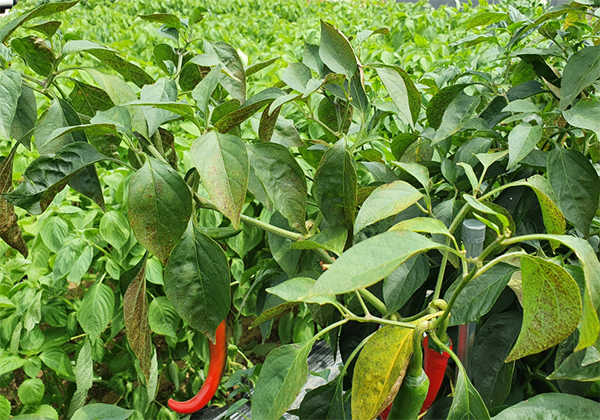

In [27]:
import os
# Assuming you have a list of class labels
class_labels = ['고추:정상', '고추:고추마일드', '고추:고추점무늬', '상추:정상', '상추:상추균핵병', '상추:상추노균병',\
                '토마토:정상', '토마토:토마토황화잎', '토마토:토마토잎곰팡이']

print("원본 데이터 이름: ",os.path.basename(img_path))
print("예측된 클래스: ",class_labels[predicted_class_index])

img = cv2.imread(img_path)
cv2_imshow(img)